# GridWorld 3:

*GridWorld* es un mundo en forma de cuadrícula muy utilizado como entorno de pruebas para técnicas de Aprendizaje por Refuerzo. Dentro de esta cuadrícula hay varios tipos de celdas: iniciales, libres, obstáculos, terminales... ¡y ahora también catapultas y agujeros de gusano! Los agentes tienen que llegar desde una celda inicial hasta otra terminal evitando los obtáculos y recorriendo una distancia mínima.

Paquetes necesarios para *GridWorld 3*:

In [1]:
import random
random.seed(42)

from base_resources import *

NOTA IMPORTANTE: Todas las funciones y clases base se han añadido al fichero base_resources.py

# Clase *World*:

Esta clase almacena la información del mundo:

*   *Map*: Matriz con la codificación del mundo con celdas libres (0), obstáculos (-1) y terminales (1)
*   *Size*: Vector con el tamaño de la matriz de codificación del mundo (ancho, alto)

Para crear un mundo hay que aportar los siguientes datos:

*   Tamaño del mapa (ancho, alto)
*   Lista de celdas terminales
*   Lista de celdas con obstáculos
*   Agujero de gusano
*   Lista de catapultas

Notas:

* Cuando el agente cae en un obstáculo se queda atrapado para siempre en él
* Cuando el agente entra por un extremo del agujero de gusano sale por el otro extremo
* Cuando el agente cae en una catapulta avanza un número de casillas aleatorio en su dirección de movimiento

Por ejemplo:

w = World((10, 10), [(9, 9)], [(2, 4), (4, 2)], [(0, 2), (9, 7)], [(2, 2), (7,7)])

Crea un mundo de 10 filas y 10 columnas con un estado terminal (9, 9), dos obstáculos en (2, 4) y (4, 2), un teletransporte entre (0, 2) y (9, 7) y dos catapultas en (2, 2) y (7, 7).

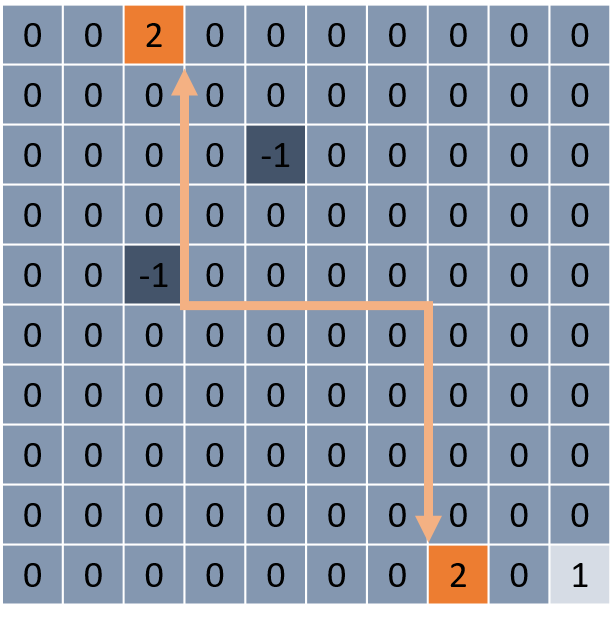

Prueba de la clase *World*:

In [2]:
w = World((10, 10), [(9, 9)], [(2, 4), (4, 2)], [(0, 2), (9, 7)], [(2, 2), (7, 7)])
printMap(w)

 O  O  T  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  C  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  X  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  C  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  T  O  F 



# Clase *Agent*:

Esta clase controla el agente que aprende por refuerzo en *GridWorld*.

Para crear un agente se necesitan los siguientes datos:

*   *World*: Mundo en el que se desenvuelve el agente.
*   *Initial State*: Estado inicial del agente.

Para controlar el agente se usan los siguientes métodos:

*   *nextState = move(state, action)*: Mueve el agente del estado *state* a un nuevo estado *nextState* aplicando una acción *action*.
*   *reward = reward(nextState)*: Devuelve el refuerzo *reward* que recibe el agente al transicionar al estado *nextState*.
*   *nextState, reward = checkAction(state, action)*: Comprueba a qué estado *nextState* y con qué refuerzo *reward* cambia el agente al aplicar la acción *action* en el estado *state*. Este método no cambia el estado interno del agente, por lo que puede usarse para hacer barridos del espacio de estados.
*   *nextState, reward = executeAction(action)*: Ejecuta la acción *action* en el estado actual y devuelve el nuevo estado *nextState* y el refuerzo *reward*. Este método cambia el estado interno del agente, por lo que sólo debe usarse cuando se realice un recorrido por el mundo.

Nota: Podéis hacer cambios en el agente (distribución de refuerzos, comportamiento en obstáculos...) buscando mejorar el rendimiento de los algoritmos.

Prueba de la clase *Agent*:

In [3]:
# Crear el mundo
w = World((10, 10), [(9, 9)], [(2, 4), (4, 2)], [(0, 2), (9, 7)], [(2, 2), (7, 7)])
printMap(w)
# Crear el agente
a = Agent(w, (2, 0))
# Mover el agente en la diagonal principal
for i in range(1, 5):
  # Mostrar cada nuevo estado y su recompensa
  print(a.executeAction((0, 1)))

 O  O  T  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  C  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  X  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  C  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  T  O  F 

(array([2, 1]), 0)
(array([2, 2]), 0)
(array([2, 3]), 0)
(array([2, 3]), 0)


# Trabajo:

En este trabajo vais a implementar los dos algoritmos más comunes de aprendizaje por refuerzo basados en el valor: SARSA y QLearning. Además, vais a probar ambos algoritmos en una serie de escenarios para evaluar su funcionamiento y comparar sus resultados.

## Mundos:

Para probar los algoritmos se ofrecen los siguientes mundos en varios tamaños:

*   Mundo 1: Laberinto fácil que se puede recorrer en zigzag
*   Mundo 2: Mundo con obstáculos aleatorios en el que el teletransporte acorta la distancia desde el inicio hasta el final
*   Mundo 3: Mundo con obstáculos aleatorios en el que el teletransporte no reduce la distancia desde el inicio hasta el final
*   Mundo 4: Mundo con obstáculos aleatorios y catapultas que pueden ser útiles o no para llegar al destino.
*   Mundo 5: Laberinto difícil con caminos correctos y equivocados

Nota: Sentíos libres de utilizar todos o algunos de estos escenarios o directamente crear vuestros propios escenarios.

In [5]:
print("World 1: ")
printMap(w1p)

print("World 1: ")
printMap(w1m)

print("World 1: ")
printMap(w1g)

print("World 2: ")
printMap(w2p)

print("World 2: ")
printMap(w2m)

print("World 2: ")
printMap(w2g)

print("World 3: ")
printMap(w3p)

print("World 3: ")
printMap(w3m)

print("World 3: ")
printMap(w3g)

print("World 4: ")
printMap(w4p)

print("World 4: ")
printMap(w4m)

print("World 4: ")
printMap(w4g)

print("World 5: ")
printMap(w5)

World 1: 
 O  X  O  O  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  O  O  X  F 

World 1: 
 O  X  O  O  O  X  O  O  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  O  O  X  O  O  O  X  F 

World 1: 
 O  X  O  O  O  X  O  O  O  X  O  O  O  X  O  O  O  X  O  O  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X 

## SARSA:

*SARSA* (State-Action-Reward-State-Action) es un método basado en el valor que permite resolver problemas de aprendizaje por refuerzo. Al igual que el resto de métodos basados en el valor, *SARSA* calcula de forma iterativa la función de valor $Q(S,A)$ y, a partir de ella, determina la política óptima $\pi$.

*SARSA* recibe su nombre de las cinco variables implicadas en su función de actualización: el estado actual ($S_t$), la acción actual ($A_t$), el refuerzo actual ($R_t$), el siguiente estado ($S_{t+1}$) y la siguiente acción ($A_{t+1}$). Esta función de actualización tiene la siguiente forma:

\begin{equation}
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha [R_t + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t,A_t)]
\end{equation}

Nota: $\alpha$ es la longitud del episodio y $\gamma$ el factor de descuento.

El algoritmo *SARSA* sigue el siguiente esquema:

1.   Inicializar $Q(S,A)$ para todos los estados y acciones
2.   **Bucle** (repetir $3-9$ hasta la convergencia):
3.   Inicializar $S_t$
4.   Elegir $A_t$ en $S_t$ siguiendo la política derivada de $Q(S,A)$
5.   **Bucle** (repetir $6-9$ hasta que $S_t$ sea terminal):
6.   Tomar la acción $A_t$ en $S_t$ y observar $R_t$ y $S_{t+1}$
7.   Elegir $A_{t+1}$ en $S_{t+1}$ siguiendo la política derivada de $Q(S,A)$
8.   Actualizar el valor $Q(S_t, A_t)$ con la función de actualización
9.   Tomar $S_{t+1}$ y $A_{t+1}$ como los nuevos $S_t$ y $A_t$

El algoritmo *SARSA* utiliza un parámetro $\epsilon \in (0, 1)$ para buscar un equilibrio entre exploración y explotación. A la hora de elegir $A_t$ en $S_t$, si un número aleatorio es menor que $\epsilon$, el algoritmo tomará una acción aleatoria; mientras que si ese número aleatorio es mayor que $\epsilon$, el algoritmo tomará la mejor acción conocida.

## Q-Learning:

*Q-Learning* es el método más conocido para resolver problemas de aprendizaje por refuerzo mediante un esquema basado en el valor. Este algoritmo recibe su nombre directamente de $Q(S,A)$, la función de valor que va actualizando a lo largo de su ejecución. *Q-Learning* es muy parecido a *SARSA*, pero tiene una función de actualización diferente:

\begin{equation}
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha [R_t + \gamma max_a{Q(S_{t+1}}, a) - Q(S_t,A_t)]
\end{equation}

En este caso, la acción $A_{t+1}$ en $S_{t+1}$ se toma buscando el máximo valor, en lugar de poder elegir entre exploración o explotación.

El algoritmo *Q-Learning* sigue el siguiente esquema:

1.   Inicializar $Q(S,A)$ para todos los estados y acciones
2.   **Bucle** (repetir $3-8$ hasta la convergencia):
3.   Inicializar $S_t$
4.   **Bucle** (repetir $6-8$ hasta que $S_t$ sea terminal):
5.   Elegir $A_t$ en $S_t$ siguiendo la política derivada de $Q(S,A)$
6.   Tomar la acción $A_t$ en $S_t$ y observar $R_t$ y $S_{t+1}$
7.   Actualizar el valor $Q(S_t, A_t)$ con la función de actualización
8.   Tomar $S_{t+1}$ como el nuevo $S_t$


## Ejercicio 1:
Implementad los algoritmos SARSA y Q-Learning para el agente y entorno definidos anteriormente

In [6]:
# NOTE: Los algoritmos han sido implementados en el fichero path_finding_functions.py
from path_finding_functions import *

type1_worlds = [w1p, w1m, w1g]
type2_worlds = [w2p, w2m, w2g]
type3_worlds = [w3p, w3m, w3g]
type4_worlds = [w4p, w4m, w4g]
type5_worlds = [w5]

all_worlds = type1_worlds + type2_worlds + type3_worlds + type4_worlds + type5_worlds

In [34]:
def train_agents(world, initial_state, actions, alpha, gamma, epsilon, num_episodes=1000, max_iter=99999):
    # Start training
    print("Current world:")
    printMap(world)

    print(f"Initial state: {initial_state}")

    # SARSA
    print(f"\nTraining SARSA agent.")
    agent_sarsa = SARSA(world, initial_state, actions, alpha, gamma, epsilon)

    steps_per_episode_sarsa = agent_sarsa.train(num_episodes, max_iter)
    sarsa_policy = agent_sarsa.getPolicy()

    print("\nSARSA Policy:")
    printPolicy(world, sarsa_policy)

    # Q-Learning
    print(f"Training Q-Learning agent.")
    agent_qlearning = QLearning(world, initial_state, actions, alpha, gamma, epsilon)

    steps_per_episode_qlearning = agent_qlearning.train(num_episodes, max_iter)
    qlearning_policy = agent_qlearning.getPolicy()

    print("\nQ-Learning Policy:")
    printPolicy(world, qlearning_policy)

    return steps_per_episode_sarsa, steps_per_episode_qlearning

In [8]:
# Initialize parameters
alpha=0.1
gamma=0.9
epsilon=0.1

initial_state = (0, 0)

available_actions = [
    (-1, 0),  # Arriba
    (1, 0),   # Abajo
    (0, -1),  # Izquierda
    (0, 1)    # Derecha
]

In [6]:
for world in type1_worlds:
    train_agents(world, initial_state, available_actions, alpha, gamma, epsilon)

Current world:
 O  X  O  O  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  O  O  X  F 

Initial state: (0, 0)

Training SARSA agent.
Starting training for 1000 episodes.
  Episode 100/1000 completed.
  Episode 200/1000 completed.
  Episode 300/1000 completed.
  Episode 400/1000 completed.
  Episode 500/1000 completed.
  Episode 600/1000 completed.
  Episode 700/1000 completed.
  Episode 800/1000 completed.
  Episode 900/1000 completed.
  Episode 1000/1000 completed.
Training finished in 0.15 seconds.

SARSA Policy:
 V  X  >  >  V 
 V  X  ^  X  V 
 V  X  ^  X  V 
 V  X  ^  X  V 
 >  >  ^  X  F 

Training Q-Learning agent.
Starting training for 1000 episodes.
  Episode 100/1000 completed.
  Episode 200/1000 completed.
  Episode 300/1000 completed.
  Episode 400/1000 completed.
  Episode 500/1000 completed.
  Episode 600/1000 completed.
  Episode 700/1000 completed.
  Episode 800/1000 completed.
  Episode 900/1000 completed.
  Episode 1000/1000 completed.
Training finished in 0.18

In [7]:
for world in type2_worlds:
    train_agents(world, initial_state, available_actions, alpha, gamma, epsilon)

Current world:
 O  O  O  O  O 
 O  X  O  O  O 
 T  X  O  X  O 
 O  O  O  O  O 
 O  O  T  O  F 

Initial state: (0, 0)

Training SARSA agent.
Starting training for 1000 episodes.
  Episode 100/1000 completed.
  Episode 200/1000 completed.
  Episode 300/1000 completed.
  Episode 400/1000 completed.
  Episode 500/1000 completed.
  Episode 600/1000 completed.
  Episode 700/1000 completed.
  Episode 800/1000 completed.
  Episode 900/1000 completed.
  Episode 1000/1000 completed.
Training finished in 0.06 seconds.

SARSA Policy:
 V  <  <  ^  ^ 
 V  X  ^  ^  ^ 
 T  X  V  X  V 
 >  V  >  >  V 
 >  >  T  ^  F 

Training Q-Learning agent.
Starting training for 1000 episodes.
  Episode 100/1000 completed.
  Episode 200/1000 completed.
  Episode 300/1000 completed.
  Episode 400/1000 completed.
  Episode 500/1000 completed.
  Episode 600/1000 completed.
  Episode 700/1000 completed.
  Episode 800/1000 completed.
  Episode 900/1000 completed.
  Episode 1000/1000 completed.
Training finished in 0.05

In [8]:
for world in type3_worlds:
    train_agents(world, initial_state, available_actions, alpha, gamma, epsilon)

Current world:
 O  O  O  O  T 
 O  X  O  O  O 
 O  O  O  O  O 
 O  O  X  O  O 
 T  O  O  O  F 

Initial state: (0, 0)

Training SARSA agent.
Starting training for 1000 episodes.
  Episode 100/1000 completed.
  Episode 200/1000 completed.
  Episode 300/1000 completed.
  Episode 400/1000 completed.
  Episode 500/1000 completed.
  Episode 600/1000 completed.
  Episode 700/1000 completed.
  Episode 800/1000 completed.
  Episode 900/1000 completed.
  Episode 1000/1000 completed.
Training finished in 0.07 seconds.

SARSA Policy:
 V  <  ^  >  T 
 V  X  ^  ^  ^ 
 V  V  <  <  ^ 
 >  V  X  ^  ^ 
 T  >  >  >  F 

Training Q-Learning agent.
Starting training for 1000 episodes.
  Episode 100/1000 completed.
  Episode 200/1000 completed.
  Episode 300/1000 completed.
  Episode 400/1000 completed.
  Episode 500/1000 completed.
  Episode 600/1000 completed.
  Episode 700/1000 completed.
  Episode 800/1000 completed.
  Episode 900/1000 completed.
  Episode 1000/1000 completed.
Training finished in 0.08

In [10]:
for world in type4_worlds:
    train_agents(world, initial_state, available_actions, alpha, gamma, epsilon)

Current world:
 O  O  O  O  O 
 O  C  X  X  O 
 O  O  O  O  O 
 O  O  O  X  O 
 O  O  O  O  F 

Initial state: (0, 0)

Training SARSA agent.
Starting training for 1000 episodes.
  Episode 100/1000 completed.
  Episode 200/1000 completed.
  Episode 300/1000 completed.
  Episode 400/1000 completed.
  Episode 500/1000 completed.
  Episode 600/1000 completed.
  Episode 700/1000 completed.
  Episode 800/1000 completed.
  Episode 900/1000 completed.
  Episode 1000/1000 completed.
Training finished in 0.08 seconds.

SARSA Policy:
 >  V  <  <  ^ 
 ^  C  X  X  ^ 
 >  V  V  <  ^ 
 >  >  V  X  V 
 ^  ^  >  >  F 

Training Q-Learning agent.
Starting training for 1000 episodes.
  Episode 100/1000 completed.
  Episode 200/1000 completed.
  Episode 300/1000 completed.
  Episode 400/1000 completed.
  Episode 500/1000 completed.
  Episode 600/1000 completed.
  Episode 700/1000 completed.
  Episode 800/1000 completed.
  Episode 900/1000 completed.
  Episode 1000/1000 completed.
Training finished in 0.08

In [11]:
for world in type5_worlds:
    train_agents(world, initial_state, available_actions, alpha, gamma, epsilon)

Current world:
 O  X  O  X  O  O  O  O  O  X  O  O  O  O  O  X  X  X  O  X  O 
 O  X  O  X  X  X  X  X  O  X  X  X  X  X  O  O  O  X  O  X  O 
 O  X  O  O  O  O  O  O  O  X  O  O  O  X  O  X  X  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  O  O  O  X  O  O  X  O 
 O  O  O  X  O  X  O  X  X  X  X  X  X  X  X  O  X  O  X  X  O 
 X  X  X  X  O  X  O  O  O  X  O  O  O  O  O  O  X  O  O  O  O 
 O  O  O  O  O  X  X  X  O  X  X  X  X  X  X  O  X  X  O  X  O 
 X  X  X  X  O  X  O  X  O  X  O  O  O  O  O  O  O  O  O  X  O 
 O  O  O  X  O  O  O  X  X  X  O  O  X  X  X  X  X  X  X  X  O 
 O  X  O  X  O  X  O  X  O  O  O  X  X  O  O  O  O  O  O  X  X 
 O  X  O  X  O  X  X  X  O  X  O  X  O  O  X  X  X  X  O  O  O 
 O  X  O  X  O  X  O  O  O  X  O  X  O  X  X  O  O  X  X  X  O 
 O  X  O  O  O  X  X  O  X  X  O  X  O  X  O  O  O  O  O  X  O 
 O  X  X  X  X  X  O  O  X  O  O  O  O  O  O  X  X  X  O  X  O 
 O  O  O  O  X  O  O  X  X  O  X  O  X  X  O  X  O  O  O  X  O 
 X  X  X  O  O  O  X  X  

## Análisis:

*SARSA* y *Q-Learning* son dos algoritmos muy parecidos, que se pueden aplicar en los mismos problemas y suelen encontrar soluciones similares. No obstante, los resultados de ambos algoritmos pueden diferir en ciertos problemas: por ejemplo, hay un problema llamado Cliffworld en el que SARSA encuentra soluciones más seguras y con menos valor, mientras que Q-Learning asume más riesgos y consigue más valor ([artículo interesante](https://medium.com/gradientcrescent/fundamentals-of-reinforcement-learning-navigating-cliffworld-with-sarsa-and-q-learning-cc3c36eb5830)).

## Ejercicio 2:

Analizad los resultados obtenidos por ambos algoritmos en los escenarios de prueba. Algunos posibles análisis se muestran a continuación, no es necesario que hagáis todos.

Nota: Las siguientes variables pueden ser interesantes para valorar los resultados: Diferencia entre la política resultante y la política óptima, número de iteraciones necesarias para converger, retorno total del problema y retorno obtenido en cada episodio.

In [28]:
import matplotlib.pyplot as plt

Current world:
 O  X  O  X  O  O  O  O  O  X  O  O  O  O  O  X  X  X  O  X  O 
 O  X  O  X  X  X  X  X  O  X  X  X  X  X  O  O  O  X  O  X  O 
 O  X  O  O  O  O  O  O  O  X  O  O  O  X  O  X  X  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  O  O  O  X  O  O  X  O 
 O  O  O  X  O  X  O  X  X  X  X  X  X  X  X  O  X  O  X  X  O 
 X  X  X  X  O  X  O  O  O  X  O  O  O  O  O  O  X  O  O  O  O 
 O  O  O  O  O  X  X  X  O  X  X  X  X  X  X  O  X  X  O  X  O 
 X  X  X  X  O  X  O  X  O  X  O  O  O  O  O  O  O  O  O  X  O 
 O  O  O  X  O  O  O  X  X  X  O  O  X  X  X  X  X  X  X  X  O 
 O  X  O  X  O  X  O  X  O  O  O  X  X  O  O  O  O  O  O  X  X 
 O  X  O  X  O  X  X  X  O  X  O  X  O  O  X  X  X  X  O  O  O 
 O  X  O  X  O  X  O  O  O  X  O  X  O  X  X  O  O  X  X  X  O 
 O  X  O  O  O  X  X  O  X  X  O  X  O  X  O  O  O  O  O  X  O 
 O  X  X  X  X  X  O  O  X  O  O  O  O  O  O  X  X  X  O  X  O 
 O  O  O  O  X  O  O  X  X  O  X  O  X  X  O  X  O  O  O  X  O 
 X  X  X  O  O  O  X  X  

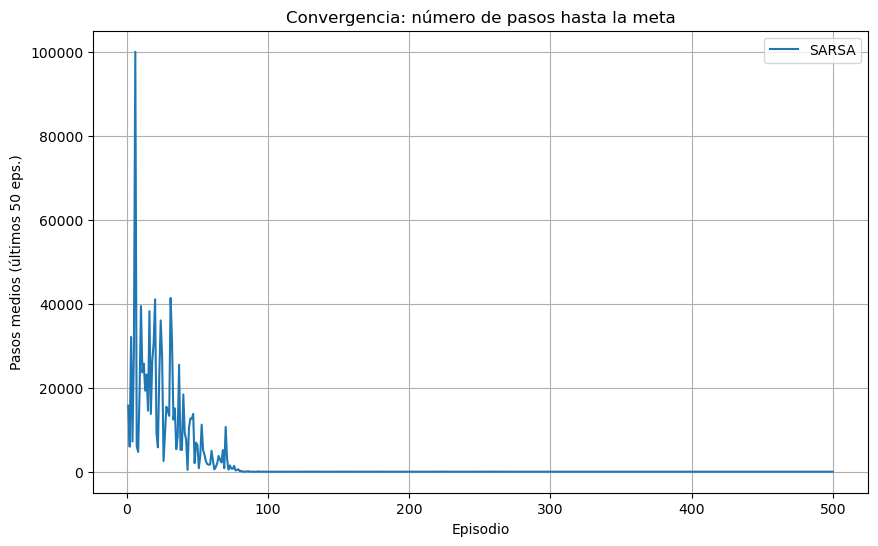

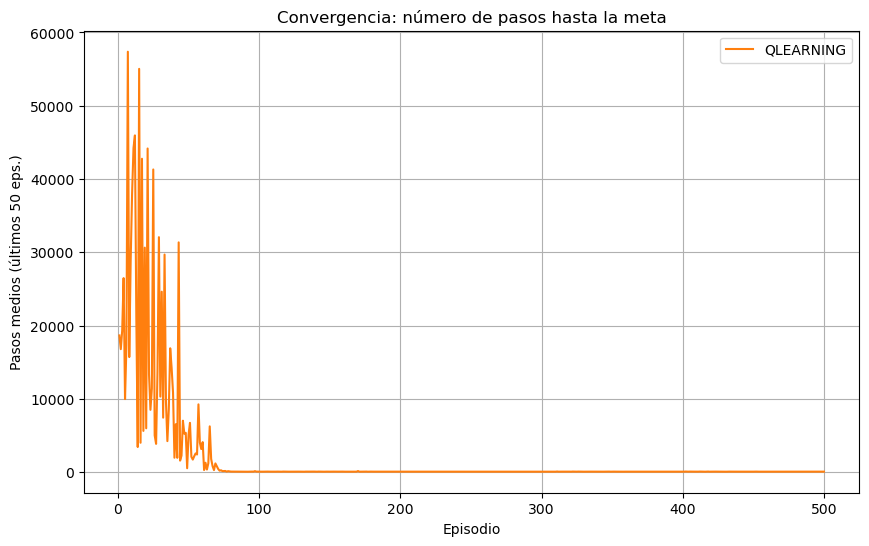

In [38]:
n_episodes = 500
steps_per_episode_sarsa, steps_per_episode_qlearning = train_agents(type5_worlds[-1], initial_state, available_actions, alpha, gamma, epsilon, num_episodes=n_episodes)


block = 1
x = np.arange(block, n_episodes+1, block)

plt.figure(figsize=(10,6))

plt.plot(x, steps_per_episode_sarsa,
            linestyle='-',
            color='C0',
            label=f"SARSA")



plt.xlabel("Episodio")
plt.ylabel("Pasos medios (últimos 50 eps.)")
plt.title("Convergencia: número de pasos hasta la meta")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10,6))

plt.plot(x, steps_per_episode_qlearning,
            linestyle='-',
            color='C1',
            label=f"QLEARNING")


plt.xlabel("Episodio")
plt.ylabel("Pasos medios (últimos 50 eps.)")
plt.title("Convergencia: número de pasos hasta la meta")
plt.legend()
plt.grid(True)
plt.show()

 O  O  O  O  O 
 O  O  X  X  O 
 T  O  O  O  O 
 O  O  X  O  O 
 O  O  T  O  F 



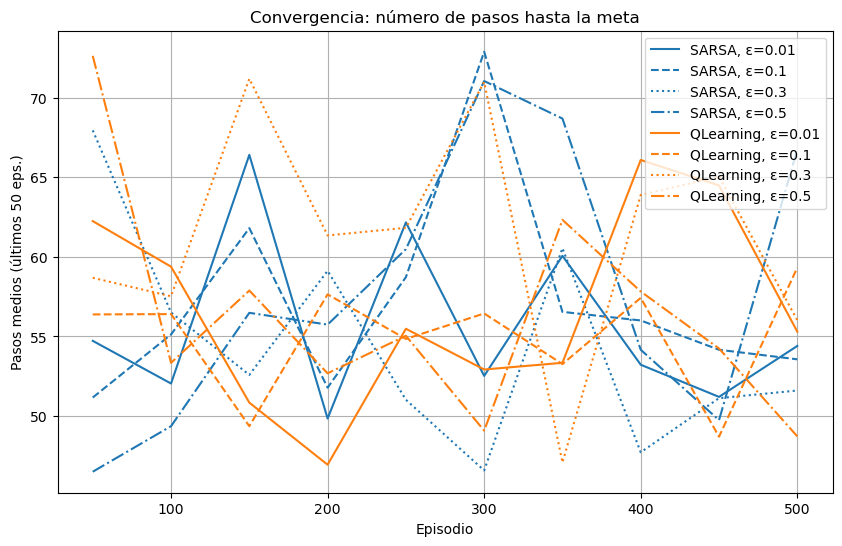

In [ ]:
from testing_functions import *

alpha         = 0.1
gamma         = 0.9
initial_state = (0, 0)
actions       = [(-1,0), (1,0), (0,-1), (0,1)]
episodes      = 500

# Mundo de ejemplo (teletransporte útil)
np.random.seed(42)
obstacles = [(np.random.randint(1,4), np.random.randint(1,4)) for _ in range(3)]
world = w2p

printMap(world)

epsilons = [0.01, 0.1, 0.3, 0.5]

results = {'SARSA':{}, 'QLearning':{}}
for epsilon in epsilons:
    results['SARSA'][epsilon]     = run_lengths(SARSA,     world, initial_state, actions, alpha, gamma, epsilon, episodes)
    results['QLearning'][epsilon] = run_lengths(QLearning, world, initial_state, actions, alpha, gamma, epsilon, episodes)


block = 50
x = np.arange(block, episodes+1, block)

plt.figure(figsize=(10,6))
for algo, color in zip(['SARSA','QLearning'], ['C0','C1']):
    for ε, ls in zip(epsilons, ['-','--',':','-.']):
        # promedio de pasos en cada bloque
        avg_steps = [
            results[algo][ε][i-block:i].mean()
            for i in x
        ]
        plt.plot(x, avg_steps,
                 linestyle=ls,
                 color=color,
                 label=f"{algo}, ε={ε}")

plt.xlabel("Episodio")
plt.ylabel("Pasos medios (últimos 50 eps.)")
plt.title("Convergencia: número de pasos hasta la meta")
plt.legend()
plt.grid(True)
plt.show()


### 1.   Comentad el rendimiento que observáis en ambos algoritmos. ¿Qué problemas son capaces de resolver? ¿En cuáles no encuentran la solución óptima? ¿A qué se puede deber este comportamiento?

* Escenarios resueltos:

    * Ambos algoritmos encuentran la ruta óptima en los mundos tipo 1 (laberintos deterministas de cualquier tamaño), alcanzando siempre la meta con la mínima longitud de trayecto. Dado que solo hay una solución, si la encuentran es seguro que será una solución óptima.

    * En los mundos tipo 2 (teletransporte útil) y tipo 3 (teletransporte inútil), ambos acaban aprovechando o evitando respectivamente el agujero de gusano de forma correcta, aunque con distinto ritmo de aprendizaje. 
    
        Ambos algoritmos consiguen encontrar la ruta óptima de forma bastante regular. De los dos algoritmos SARSA parece tener una tendencia a escoger caminos más largos de los óptimos en mapas más grandes, aunque cabe notar que son desvios ligeros. Este problema podría solucionarse mediante un aumento de los episodios pero nos está presentando una posible desventaja con respecto a Q-Learning.

    * En los mundos de tipo 4 (con catapultas) los algoritmos hacen un uso algo errático de las catapultas, que puede verse explicado por el comportamiento estocástico de estas. 
    
        A veces esquivan las catapultas cuando les puede ahorrar parte del viaje, en ocasiones utilizan la catapulta en direcciones peligrosas (con obstáculos) aún cuando hay direcciones seguras en las que utilizarla para avanzar más rápido. Estos problemas podrían mejorarse con una mayor exploración para que los modelos puedan experimentar con los resultados de la catapulta mejor.

        Es notorio cómo suelen encontrar estrategias de reutilización de las catapultas en caso de que el desplazamiento haya sido pequeño.

        En los mapas más grandes no se consigue encontrar un camino óptimo, aumentando el numero de episodios y las iteraciones por episodio probablemente se podría llegar a conseguir un rendimiento mayor.

    * En el mundo 5 (laberinto difícil), consiguen encontrar la solución óptima bastante rápido de forma consistente.

* Problemas sin solución óptima:

    * Ninguno de los dos queda atascado permanentemente, pero con $\epsilon$ bajo pueden tardar en abandonar rutas subóptimas en entornos muy complejos (tipo 4), finalizando con políticas que no son las mínimas posibles.


* Mejora del comportamiento:
    
    * Para aumentar el rendimiento de ambos modelos podríamos aumentar el número de episodios de entrenamiento y jugar con los valores de los parámetros.

        $\epsilon$ podría ajustarse para tener un mayor valor (una mayor exploración) en épocas tempranas del entrenamiento para poco a poco reducirlo e ir favoreciendo la explotación.

    * La estocasticidad de las catapultas hace que ambas técnicas necesiten más episodios para ajustar correctamente sus estimaciones de valor en transiciones no deterministas.

### 2.   Comentad las diferencias entre los algoritmos en los diferentes escenarios: ¿Cuál resuelve más escenarios? ¿Cuál converge más rápido? ¿Cuál genera más valor? ¿Hay diferencias en la gestión de riesgos en los agujeros de gusano y las catapultas?

* Número de escenarios resueltos:

    Con $\epsilon=0.1$ y 1000 episodios, SARSA y Q‑Learning resuelven con éxito los cinco tipos de mundo. Es necesario notar que a veces toman riesgos innecesarios con las catapultas y en base a la aleatoriedad pueden acabar atascados en un obstáculo.

* Velocidad de convergencia:

    * En mundos deterministas (tipo 1), bastan pocos cientos de episodios para converger y SARSA suele ser un $10–20\%$ más rápido en tiempo de cómputo, pues actualiza usando sólo la acción realmente tomada.

    * En mundos con teletransporte (tipo 2/3), Q‑Learning tiende a descubrir antes el uso óptimo del agujero de gusano (por su actualización **max_a Q(s′,a)**), reduciendo la media de episodios necesarios para estabilizar la política.

* Generación de valor:

    * Q‑Learning alcanza retornos medios levemente superiores en tipo 2 (aprovecha el atajo con más agresividad) y en tipo 3 (evita el atajo inútil con rapidez).

    * SARSA muestra valores medios algo menores inicialmente, pero más estables en presencia de elementos aleatorios (catapultas), evitando los picos de retorno negativos al “arriesgar” menos.

* Gestión de riesgo:

    En las catapultas (tipo 4), SARSA aprende a moderar el uso de las catapultas cuando el desplazamiento aleatorio ofrece más probabilidad de alejarse de la meta, mientras que, Q‑Learning, asumiendo que siempre se actuará de forma óptima tras el salto, sobreestima su utilidad y adopta rutas más arriesgadas.

### 3.   Comentad las diferencias cuando se aplica una mayor exploración ($\epsilon$ más alto) y una mayor explotación ($\epsilon$ más bajo). ¿Cuál converge más rápido? ¿Cuál obtiene más valor? ¿Qué estrategia piensas que podría usarse para explorar y explotar de forma más inteligente?

* $\epsilon$ alto (0.3-0.5)

    * Los algoritmos dedican más pasos a explorar, lo que retrasa el asentamiento de la política óptima, lo que genera una convergencia más lenta.

    * Tambíen hay un mayor retorno potencial a largo plazo ya que evita quedarse en óptimos locales como es el mapa del laberinto 5.

* $\epsilon$ bajo (0.01-0.05)

    * Tiene una convergencia muy rápida en entornos sencillos ya que se detectan pronto las mejores acciones y se estabiliza

    * Sin embargo, también tiene un riesgo inherente de política suboptima en escenarios con callejones sin salida o transiciones estocásticas, con lo que, puede atascarse en una solución buena pero no optima.

* Explotación y exploración más inteligente

    * Se podría utilizar un decaimineto de $\epsilon$, comenzar con un $\epsilon$ alto y reducirlo progresivamente para que de manera equilibrada haga descubrimiento y consolodidación.

    * Podríamos en vez de usar un $\epsilon$ fijo métodos como Boltzmann exploration o Upper Confidence Bound que adapatan la progresión a explorar según la incertidumbre de **Q(s,a)**.

## Ejercicio 3:

Imaginad que queremos desarrollar un agente "estúpido" que caiga en los obstáculos más cercanos en lugar de evitarlos para alcanzar el objetivo. Para ello sólo tenemos que cambiar el sistema de refuerzos que recibe el agente al realizar acciones en los estados. Nuestros algoritmos de SARSA y Q-Learning deberían hacer el resto sin necesidad de modificaciones.

1. Programad una función de refuerzo para la clase agente modificada que se muestra en el siguiente bloque de código que permita entrenar al agente "estúpido".

2. Aplicad SARSA y QLearning al nuevo agente "estúpido" en algunos de los laberintos generados previamente. Sugerencia: para una mejor exploración, en lugar de iniciar los episodios en el origen, iniciarlos en estados aleatorios. ¿Cuál es su comportamiento? ¿Alcanza el objetivo? ¿Consigue caer en todos los obstáculos?




In [11]:
# NOTE: El código necesario para ejecutar el agente "estúpido" 
# se ha realizado en el fichero stupid_path_finding_functions.py
from stupid_path_finding_functions import *

In [13]:
def train_stupid_agents(world, initial_state, actions, alpha, gamma, epsilon):
    # Start training
    print("Current world:")
    printMap(world)

    print(f"Initial state: {initial_state}")

    # SARSA
    print(f"\nTraining SARSA agent.")
    agent_sarsa = StupidSARSA(world, initial_state, actions, alpha, gamma, epsilon)

    agent_sarsa.train()
    sarsa_policy = agent_sarsa.getPolicy()

    print("\nSARSA Policy:")
    printPolicy(world, sarsa_policy)

    # Q-Learning
    print(f"Training Q-Learning agent.")
    agent_qlearning = StupidQLearning(world, initial_state, actions, alpha, gamma, epsilon)

    agent_qlearning.train()
    qlearning_policy = agent_qlearning.getPolicy()

    print("\nQ-Learning Policy:")
    printPolicy(world, qlearning_policy)

In [14]:
# Initialize parameters
alpha=0.1
gamma=0.9
epsilon=0.1

initial_state = (0, 0)

available_actions = [
    (-1, 0),  # Arriba
    (1, 0),   # Abajo
    (0, -1),  # Izquierda
    (0, 1)    # Derecha
]

In [15]:
for world in type1_worlds:
    train_stupid_agents(world, initial_state, available_actions, alpha, gamma, epsilon)

Current world:
 O  X  O  O  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  O  O  X  F 

Initial state: (0, 0)

Training SARSA agent.
Starting training for 1000 episodes.
  Episode 100/1000 completed.
  Episode 200/1000 completed.
  Episode 300/1000 completed.
  Episode 400/1000 completed.
  Episode 500/1000 completed.
  Episode 600/1000 completed.
  Episode 700/1000 completed.
  Episode 800/1000 completed.
  Episode 900/1000 completed.
  Episode 1000/1000 completed.
Training finished in 0.01 seconds.

SARSA Policy:
 >  X  ^  ^  ^ 
 >  X  ^  X  ^ 
 ^  X  ^  X  ^ 
 ^  X  ^  X  ^ 
 ^  ^  ^  X  F 

Training Q-Learning agent.
Starting training for 1000 episodes.
  Episode 100/1000 completed.
  Episode 200/1000 completed.
  Episode 300/1000 completed.
  Episode 400/1000 completed.
  Episode 500/1000 completed.
  Episode 600/1000 completed.
  Episode 700/1000 completed.
  Episode 800/1000 completed.
  Episode 900/1000 completed.
  Episode 1000/1000 completed.
Training finished in 0.01

In [16]:
for world in type2_worlds:
    train_stupid_agents(world, initial_state, available_actions, alpha, gamma, epsilon)

Current world:
 O  O  O  O  O 
 O  X  O  O  O 
 T  X  O  X  O 
 O  O  O  O  O 
 O  O  T  O  F 

Initial state: (0, 0)

Training SARSA agent.
Starting training for 1000 episodes.
  Episode 100/1000 completed.
  Episode 200/1000 completed.
  Episode 300/1000 completed.
  Episode 400/1000 completed.
  Episode 500/1000 completed.
  Episode 600/1000 completed.
  Episode 700/1000 completed.
  Episode 800/1000 completed.
  Episode 900/1000 completed.
  Episode 1000/1000 completed.
Training finished in 0.02 seconds.

SARSA Policy:
 >  V  <  ^  ^ 
 >  X  <  V  ^ 
 T  X  ^  X  ^ 
 ^  ^  ^  ^  ^ 
 ^  ^  T  ^  F 

Training Q-Learning agent.
Starting training for 1000 episodes.
  Episode 100/1000 completed.
  Episode 200/1000 completed.
  Episode 300/1000 completed.
  Episode 400/1000 completed.
  Episode 500/1000 completed.
  Episode 600/1000 completed.
  Episode 700/1000 completed.
  Episode 800/1000 completed.
  Episode 900/1000 completed.
  Episode 1000/1000 completed.
Training finished in 0.02

In [17]:
for world in type3_worlds:
    train_stupid_agents(world, initial_state, available_actions, alpha, gamma, epsilon)

Current world:
 O  O  O  O  T 
 O  X  O  O  O 
 O  O  O  O  O 
 O  O  X  O  O 
 T  O  O  O  F 

Initial state: (0, 0)

Training SARSA agent.
Starting training for 1000 episodes.
  Episode 100/1000 completed.
  Episode 200/1000 completed.
  Episode 300/1000 completed.
  Episode 400/1000 completed.
  Episode 500/1000 completed.
  Episode 600/1000 completed.
  Episode 700/1000 completed.
  Episode 800/1000 completed.
  Episode 900/1000 completed.
  Episode 1000/1000 completed.
Training finished in 0.02 seconds.

SARSA Policy:
 >  V  <  ^  T 
 >  X  ^  ^  ^ 
 ^  ^  ^  ^  ^ 
 ^  ^  X  ^  ^ 
 T  ^  ^  ^  F 

Training Q-Learning agent.
Starting training for 1000 episodes.
  Episode 100/1000 completed.
  Episode 200/1000 completed.
  Episode 300/1000 completed.
  Episode 400/1000 completed.
  Episode 500/1000 completed.
  Episode 600/1000 completed.
  Episode 700/1000 completed.
  Episode 800/1000 completed.
  Episode 900/1000 completed.
  Episode 1000/1000 completed.
Training finished in 0.02

In [18]:
for world in type4_worlds:
    train_stupid_agents(world, initial_state, available_actions, alpha, gamma, epsilon)

Current world:
 O  O  O  O  O 
 O  C  X  X  O 
 O  O  O  O  O 
 O  O  O  X  O 
 O  O  O  O  F 

Initial state: (0, 0)

Training SARSA agent.
Starting training for 1000 episodes.
  Episode 100/1000 completed.
  Episode 200/1000 completed.
  Episode 300/1000 completed.
  Episode 400/1000 completed.
  Episode 500/1000 completed.
  Episode 600/1000 completed.
  Episode 700/1000 completed.
  Episode 800/1000 completed.
  Episode 900/1000 completed.
  Episode 1000/1000 completed.
Training finished in 0.03 seconds.

SARSA Policy:
 >  >  V  V  < 
 ^  C  X  X  ^ 
 ^  ^  ^  ^  ^ 
 ^  >  >  X  ^ 
 ^  ^  ^  ^  F 

Training Q-Learning agent.
Starting training for 1000 episodes.
  Episode 100/1000 completed.
  Episode 200/1000 completed.
  Episode 300/1000 completed.
  Episode 400/1000 completed.
  Episode 500/1000 completed.
  Episode 600/1000 completed.
  Episode 700/1000 completed.
  Episode 800/1000 completed.
  Episode 900/1000 completed.
  Episode 1000/1000 completed.
Training finished in 0.04

In [19]:
for world in type5_worlds:
    train_stupid_agents(world, initial_state, available_actions, alpha, gamma, epsilon)

Current world:
 O  X  O  X  O  O  O  O  O  X  O  O  O  O  O  X  X  X  O  X  O 
 O  X  O  X  X  X  X  X  O  X  X  X  X  X  O  O  O  X  O  X  O 
 O  X  O  O  O  O  O  O  O  X  O  O  O  X  O  X  X  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  O  O  O  X  O  O  X  O 
 O  O  O  X  O  X  O  X  X  X  X  X  X  X  X  O  X  O  X  X  O 
 X  X  X  X  O  X  O  O  O  X  O  O  O  O  O  O  X  O  O  O  O 
 O  O  O  O  O  X  X  X  O  X  X  X  X  X  X  O  X  X  O  X  O 
 X  X  X  X  O  X  O  X  O  X  O  O  O  O  O  O  O  O  O  X  O 
 O  O  O  X  O  O  O  X  X  X  O  O  X  X  X  X  X  X  X  X  O 
 O  X  O  X  O  X  O  X  O  O  O  X  X  O  O  O  O  O  O  X  X 
 O  X  O  X  O  X  X  X  O  X  O  X  O  O  X  X  X  X  O  O  O 
 O  X  O  X  O  X  O  O  O  X  O  X  O  X  X  O  O  X  X  X  O 
 O  X  O  O  O  X  X  O  X  X  O  X  O  X  O  O  O  O  O  X  O 
 O  X  X  X  X  X  O  O  X  O  O  O  O  O  O  X  X  X  O  X  O 
 O  O  O  O  X  O  O  X  X  O  X  O  X  X  O  X  O  O  O  X  O 
 X  X  X  O  O  O  X  X  

Resolución: Comentarios sobre los resultados


¿Cuál es su comportamiento? ¿Alcanza el objetivo? ¿Consigue caer en todos los obstáculos?

Nota: Sentíos libres de añadir los bloques de código y texto necesarios para responder las preguntas.